# Using Stock Indicators with a MLP Neural Network to predict stock prices

* 273 days of historical AAPL daily adjusted close price 
* Predicts end of year last 92 days adjusted close price
* 59 Technical Indicators are used from https://github.com/bukosabino/ta
* Trained Neural Network 

In [1]:
import sys

sys.path.append("..")
from utils.Db import Db
import pandas as pd
import datetime
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from datetime import datetime 
from datetime import timedelta

In [2]:
plt.rcParams["figure.figsize"] = [9, 6]
%matplotlib notebook

In [11]:
db = Db("../cache")
df = db.get_symbols_as_dataframe(['AAPL'])
df['date_time'] = pd.to_datetime(df['date_time'])
df = add_all_ta_features(df, "open", "high", "low", "close", "volume")
df = df.dropna()
columns = df.columns.values[9:].tolist() + ["unix_time"]

source_data = df[columns].as_matrix()
training_data = source_data[:int(len(source_data) * .98)]
testing_data = source_data[len(training_data):]
target = df['adjusted_close'].as_matrix()
testing_target = target[len(training_data):]
target = target[:len(training_data)]

min_max_scaler = preprocessing.MinMaxScaler()

C:\python36_64\lib\site-packages\ta\trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
C:\python36_64\lib\site-packages\ta\trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


In [15]:
x_train_minmax = min_max_scaler.fit_transform(training_data)

model = MLPRegressor(hidden_layer_sizes=400, alpha=0.001, verbose=False, max_iter=99999999,
                     tol=1e-20, learning_rate_init=0.001, learning_rate="adaptive")
model.fit(x_train_minmax, target)

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=400, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=99999999, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-20, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [16]:
test_output = model.predict(min_max_scaler.transform(testing_data))
train_test_output = model.predict(x_train_minmax)
errors = np.abs(testing_target - test_output)
print(np.std(errors))
print(np.mean(errors))

7.93241151211
18.2041777209


<IPython.core.display.Javascript object>


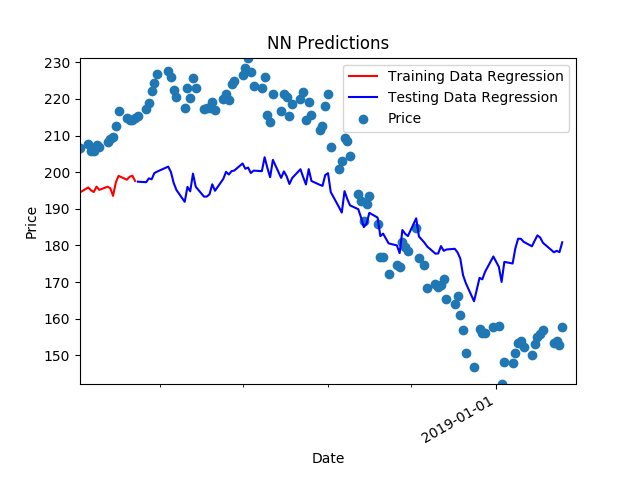

In [17]:
years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
yearsFmt = mdates.DateFormatter('%Y-%m-%d')

fig = plt.figure()
ax = fig.add_subplot(111)

matrix_data = df.as_matrix()
x_vals = matrix_data[:, 1]
ax.scatter(x_vals, df['adjusted_close'].tolist(), label='Price')
ax.plot(x_vals[:len(train_test_output)], train_test_output, label='Training Data Regression', color='red')
ax.plot(x_vals[len(train_test_output):], test_output, label='Testing Data Regression', color='blue')

left = x_vals[-120]
right = x_vals[-1] + timedelta(days=5)
ax.set_xlim(left=left, right=right)
bottom = df.tail(120)['adjusted_close'].min()
top = df.tail(120)['adjusted_close'].max()
ax.set_ylim(top=top, bottom=bottom)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('NN Predictions')
plt.legend()

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.show()